#Dependencies and Functions

In [1]:
# @title Dependencies

# Import libraries after connection to Runtime
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import linregress
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression

In [2]:
# @title Functions

# @title Function 1: Read the raw data

# Reading the csv files in directory.
def read_csv(directory):
    csv_files = sorted([file for file in os.listdir(directory) if file.endswith('.csv')])

    for i in csv_files:
      print(i)
    return csv_files

# @title Function 2: Process the raw data
def process_data(directory, csv_files, wavelength_start, wavelength_end, threshold=4):
    data_dict = {}
    for filename in csv_files:
        # Initialize variables
        a = 0
        b = 0
        amplitude = []

        # Open the CSV file and read data
        with open(os.path.join(directory, filename), newline='') as f:
            reader = csv.reader(f, delimiter=",")
            header_row = next(reader)  # Skip header row
            next(reader)  # Skip additional rows (assuming they're metadata)
            next(reader)  # Skip additional rows (assuming they're metadata)
            data_number = 0

            # Process each row in the CSV file
            for row in reader:
                trigger_amplitude = float(row[1].replace(",", "."))

                # Check if trigger amplitude exceeds threshold
                if trigger_amplitude > threshold:
                    a = 1
                    b = 0

                # If trigger amplitude condition is met, process amplitude values
                if a == 1:
                    amplitude_value = float(row[2].replace(",", "."))
                    amplitude.append(amplitude_value)
                    b += 1
                    data_number += 1

                    # Reset trigger condition after collecting 5 amplitude values
                    if b > 4:
                        a = 0

        # Calculate wavenumbers
        wavenumber = []
        step = (wavelength_end - wavelength_start) / data_number
        wavelength_list = wavelength_start
        for r in range(1, data_number + 1):
            wavenumber.append(wavelength_list)
            wavelength_list += step

        # Store wavenumber and amplitude values in the dictionary
        data_dict[filename] = {'wavenumber': wavenumber, 'amplitude': amplitude}

    return data_dict

# @title Function 3: Plot and Manipulate
def plot_peaks(data_dict, xlim_start, xlim_end, prominence, peak_max=1.0, size_figure=1.5):
    data_peak = {}



    for filename, data in data_dict.items():
        amplitude = np.array(data['amplitude'])
        wavenumber = np.array(data['wavenumber'])

        # Reshape the data to fit the requirements of RobustScaler
        channel_B_reshaped = amplitude.reshape(-1, 1)

        # Replace infinite values with NaN before scaling
        channel_B_reshaped = np.where(np.isinf(channel_B_reshaped), np.nan, channel_B_reshaped)

        # Find negative peaks using scipy.signal.find_peaks
        peaks, _ = find_peaks(-amplitude.flatten(), prominence=prominence)

        filtered_peaks = [idx for idx in peaks if amplitude.flatten()[idx] < peak_max]

        # Get x and y coordinates of the negative peaks
        peaks_x = wavenumber[filtered_peaks]
        peaks_y = amplitude.flatten()[filtered_peaks]

        # Plot the graph with normalized y-axis data and detected negative peaks
        fig, ax = plt.subplots(figsize=(15, size_figure))
        ax.plot(wavenumber, amplitude)
        ax.plot(peaks_x, peaks_y, 'r.', label='Negative Peaks')
        ax.set_xlabel('Wavelength [nm]')
        ax.set_ylabel('Voltage [V]')
        ax.set_title(f'{filename}')
        ax.set_xlim(xlim_start, xlim_end)
        plt.grid(True)

        # Create DataFrame from peak coordinates
        peak_df = pd.DataFrame({'Wavenumber': peaks_x, 'Voltage': peaks_y})
        data_peak[filename] = {'wavenumber': peaks_x, 'amplitude': peaks_y}

        plt.tight_layout()
        plt.show()


    # Create an empty DataFrame to store all data
    all_data = pd.DataFrame(columns=['Filename', 'Wavenumber', 'Amplitude'])

    # Iterate through each filename in the data_peak library
    for filename, data in data_peak.items():
        # Create a DataFrame from the wavenumber and amplitude arrays
        df = pd.DataFrame({'Wavenumber': data['wavenumber'], 'Amplitude': data['amplitude']})

        # Add the 'Filename' column to the DataFrame
        df['Filename'] = filename

        # Append the DataFrame to the all_data DataFrame
        all_data = pd.concat([all_data, df], ignore_index=True)

    # Initialize an empty dictionary to store filtered data
    filtered_data = {}

    # Iterate through each filename to filter wavenumber values
    for filename in all_data['Filename'].unique():
        # Extract data for the current filename
        filename_data = all_data[all_data['Filename'] == filename]

        # Initialize a list to store the indices of rows to keep
        rows_to_keep = [0]  # Keep the first row

        # Iterate through the data and check wavenumber differences between successive rows
        for i in range(1, len(filename_data)):
            # Calculate the difference in wavenumber between successive rows
            wavenumber_diff = filename_data.iloc[i]['Wavenumber'] - filename_data.iloc[i - 1]['Wavenumber']

            # If the difference is greater than or equal to the minimum difference, keep the row
            if wavenumber_diff >= 0.01:
                rows_to_keep.append(i)

        # Filter the DataFrame based on the identified rows to keep
        filtered_filename_data = filename_data.iloc[rows_to_keep]

        # Store the filtered data for the current filename
        filtered_data[filename] = filtered_filename_data

    # Create subplots
    fig, axs = plt.subplots(len(filtered_data), figsize=(15, 1.5*len(filtered_data)))

    # Iterate through each filename and its corresponding filtered data
    for i, (filename, data) in enumerate(filtered_data.items()):
        # Plot the wavenumber against index for the current filename with a constant y-value
        axs[i].scatter(data['Wavenumber'], [0] * len(data), label=filename, color="red")
        axs[i].set_title(f'Wavelength-Index Plot - {filename}')
        axs[i].set_xlabel('Wavelength [nm]')
        axs[i].set_xlim(xlim_start, xlim_end)
        axs[i].grid(True)



        # Annotate each point with its index and wavenumber
        for index, (x, y) in enumerate(zip(data['Wavenumber'], data.index)):
            axs[i].annotate(y, (x, 0), textcoords="offset points", xytext=(5,5), ha='center', size=8)

    print("\n # # # # # # # # # # # \n")

    # Adjust layout to prevent overlapping of subplots
    plt.tight_layout()
    plt.show()

    return filtered_data, data_peak

# @title Function 4: Wavelength Shift Calculation
def get_wavenumber_differences(filtered_data):
    reference_data = {}  # Dictionary to save the reference wavenumber data
    differences = []  # List to save the calculated differences
    selected_indexes = []  # List to save the indexes of selected points
    selected_wavenumbers = []
    inputs = []

    # Ask the user to input the index of the reference point
    while True:
        reference_input = input("Enter the index of the reference point or 'terminate' to stop: ")
        if reference_input.lower() == 'terminate':
            break  # Exit the loop if "terminate" is entered
        try:
            # Convert the user input to an integer (index)
            reference_index = int(reference_input)
            # Iterate through each filename and its corresponding filtered data
            for filename, data in filtered_data.items():
                # Check if the input index exists in the current filename's data
                if reference_index in data.index:
                    # Retrieve the wavenumber value for the specified index
                    reference_wavenumber = data.loc[reference_index, 'Wavenumber']
                    # Print the reference wavenumber value
                    print("Reference wavenumber value for index", reference_index, "in", filename, ":", reference_wavenumber)
                    # Save the reference wavenumber along with its filename and index
                    reference_data = {'Filename': filename, 'Index': reference_index, 'Wavenumber': reference_wavenumber}
                    selected_indexes.append(reference_index)  # Save the index of the reference point
                    inputs.append((filename, reference_index, reference_wavenumber))
                    selected_wavenumbers.append(reference_wavenumber)
                    break  # Exit the for loop if the reference wavenumber is found
            else:
                # If the input index is not found in any of the filenames' data
                print("Index", reference_index, "not found in any filenames.")
        except ValueError:
            print("Invalid input. Please enter an index (integer) or 'terminate'.")

        # Break out of the loop if a valid reference wavenumber is set
        if reference_data:
            break

    # Create a list to store the provided wavenumbers and their corresponding filenames


    print("\nPlease enter the index for corresponding wavenumbers.")
    # While loop to continuously provide wavenumber values until "terminate" is written
    while True:
        # Ask the user to input an index or "terminate"
        user_input = input("Enter an index to retrieve the corresponding wavenumber or 'terminate' to stop: ")

        # Check if the user wants to terminate
        if user_input.lower() == 'terminate':
            break  # Exit the while loop if "terminate" is entered


        try:
            # Convert the user input to an integer (index)
            index = int(user_input)

            # Iterate through each filename and its corresponding filtered data
            for filename, data in filtered_data.items():
                # Check if the input index exists in the current filename's data
                if index in data.index:
                    # Retrieve the wavenumber value for the specified index
                    wavenumber_value = data.loc[index, 'Wavenumber']
                    # Print the wavenumber value
                    print("Wavenumber value for index", index, "in", filename, ":", wavenumber_value)
                    # Add the provided wavenumber and its filename to the list
                    inputs.append((filename, index, wavenumber_value))
                    selected_indexes.append(index)  # Save the index of the selected point
                    selected_wavenumbers.append(wavenumber_value)
                    break  # Exit the for loop if the wavenumber is found
            else:
                # If the input index is not found in any of the filenames' data
                print("Index", index, "not found in any filenames.")
        except ValueError:
            print("Invalid input. Please enter an index (integer) or 'terminate'.")

    # If the user provided any inputs, calculate and save the differences from the reference wavenumber

    if inputs:
        print("\nDifferences from the reference wavenumber:")
        for filename, index, wavenumber_value in inputs:
            difference = (wavenumber_value - reference_data['Wavenumber'])
            print(f"Difference for index {index} in {filename}: {difference}")
            # Save the difference along with its filename and index
            differences.append({'Filename': filename, 'Index': index, 'Difference': difference})
    else:
        print("No inputs provided. Exiting.")

    return reference_data, differences, selected_indexes, selected_wavenumbers

# @title Function 5: Wavelength Shift Plot
def plot_wavelength_shift(differences, selected_indexes, filtered_data):
    # Extract filename and difference values from the differences list
    filenames = [entry['Filename'] for entry in differences]
    difference_values = [entry['Difference'] for entry in differences]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot wavenumber differences
    axs[0].scatter(filenames, difference_values, color='black', marker='o', label='Data')
    axs[0].set_ylabel('Wavelength Shift [nm]')
    axs[0].set_title('∆λ')
    axs[0].grid(True)

    # Rotate and align x-axis labels for the first subplot
    plt.sca(axs[0])
    plt.xticks(rotation=45, ha='right')

    # Perform linear regression for wavenumber differences
    X = np.arange(len(filenames)).reshape(-1, 1)  # Reshape X to a column vector
    y = np.array(difference_values)
    regression_model = LinearRegression().fit(X, y)
    regression_line = regression_model.predict(X)
    axs[0].plot(filenames, regression_line, color='red', linestyle='--', label='Linear Regression')

    # Perform polynomial regression for wavenumber differences
    degree = 3  # Degree of the polynomial
    coefficients = np.polyfit(X.flatten(), y, degree)
    polynomial = np.poly1d(coefficients)
    axs[0].plot(filenames, polynomial(X), color='blue', linestyle='-', label=f'Polynomial (Degree {degree})')

    # Add a horizontal line at y=0
    axs[0].axhline(0, color='gray', linestyle='-', linewidth=2)

    all_points = []
    for index in selected_indexes:
        # Iterate through each filename and its corresponding filtered data
        for filename, data in filtered_data.items():
            # Check if the input index exists in the current filename's data
            if index in data.index:
                # Retrieve the wavenumber value for the specified index
                wavenumber_value = data.loc[index, 'Wavenumber']
                # Add the wavenumber value and its filename to the list
                all_points.append((filename, wavenumber_value))
                break  # Exit the for loop if the wavenumber is found

    e = 2.718281828459045
    # Plot selected points with a line plot
    x_values = [filename for filename, _ in all_points]  # Extract filenames
    y_values = [wavenumber_value for _, wavenumber_value in all_points]  # Extract wavenumber values

    axs[1].plot(x_values, y_values, color='black', linestyle='-', marker='o', label='Selected Points')

    # Set labels and title for the second subplot
    axs[1].set_ylabel('Wavelength [nm]')
    #axs[1].set_title() - set title
    axs[1].grid(True)

    # Rotate and align x-axis labels for the second subplot
    plt.sca(axs[1])
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# @title Function 6: Wavelenght Shift Plot based on two peak differences
def show_wavenumbers(filtered_data, selected_indexes):
    print('Selected indexes are', selected_indexes, '\n')

    # Ask if there are any missing indexes to add
    while True:
        missing_input = input('Are there any missing indexes to add (Y/N)? ').upper()
        if missing_input == 'Y':
            while True:
                missing_index = input('Enter the missing index to add or "No" to stop: ')
                if missing_index.upper() == 'NO':
                    break
                try:
                    index_to_add = int(missing_index)
                    selected_indexes.append(index_to_add)
                    print(f"Index {index_to_add} added to selected indexes.")
                except ValueError:
                    print("Invalid input. Please enter an integer or 'No' to stop.")
        elif missing_input == 'N':
            break
        else:
            print("Invalid input. Please enter 'Y' for yes or 'N' for no.")

    # Ask the user to choose between automatic or manual input for next indexes
    while True:
        choice = input('Do you want to find the next indexes automatically (A) or manually (M)? ').upper()
        if choice == 'A':
            automatic = True
            break
        elif choice == 'M':
            automatic = False
            break
        else:
            print("Invalid choice. Please enter 'A' for automatic or 'M' for manual.")

    selected_indexes = sorted(selected_indexes)
    btw = []  # List to store the differences between consecutive wavenumber values
    filenames = []  # List to store the corresponding filenames

    # Iterate through selected indexes and find differences with next index
    for index in selected_indexes:
        for filename, data in filtered_data.items():
            # Check if the input index exists in the current filename's data
            if index in data.index:
                wavenumber_value = data.loc[index, 'Wavenumber']

                # Retrieve the wavenumber value for the next index
                if automatic:
                    next_index = index + 1
                    while next_index not in data.index:
                        next_index += 1
                    wavenumber_value_next = data.loc[next_index, 'Wavenumber']
                else:
                    try:
                        next_index = int(input(f"Enter the next index after {index} in {filename}: "))
                        wavenumber_value_next = data.loc[next_index, 'Wavenumber']
                    except ValueError:
                        print("Invalid input. Please enter an integer.")
                        continue

                difference = abs(wavenumber_value - wavenumber_value_next)
                btw.append(difference)
                filenames.append(filename)

                # Print the wavenumber value and the difference
                print(f"Wavelength for index {index} in {filename}: {wavenumber_value}")
                print(f"Wavelength for the next index {next_index} in {filename}: {wavenumber_value_next}")
                print(f"Difference between consecutive wavelength: {difference}\n")

                break  # Exit the for loop if the wavenumber is found
        else:
            # If the input index is not found in any of the filenames' data
            print(f"Index {index} not found in any filenames.")

    # Plot differences along with filenames
    plt.figure(figsize=(10, 6))
    plt.scatter(filenames, btw, color='black')
    plt.xlabel('Filename')
    plt.ylabel('Wavelength Difference [nm]')
    plt.title('Wavelength Shift between Consecutive Indexes')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)

    slope, intercept, _, _, _ = linregress(range(len(btw)), btw)
    regression_line = [slope * x + intercept for x in range(len(btw))]
    plt.plot(filenames, regression_line, color='red', linestyle='--', label='Linear Regression')

    #plt.legend()
    plt.tight_layout()
    plt.show()

# Running the Functions and Analyzation

In [3]:
# Indicate start and end of wavelength sweep

wavelength_start = 1551
wavelength_end = 1555
directory = '/content/'                                                           # Upload files to Google Colab files. Content file is general location where Google Colab provides.

# After uploading the files, this very cell can be initialized. As an output, data files will be appeared below.

csv_files = read_csv(directory)
data_dict = process_data(directory, csv_files, wavelength_start, wavelength_end)

0% NaCl.csv
01% NaCl.csv
05% NaCl.csv
10% NaCl.csv
15% NaCl.csv


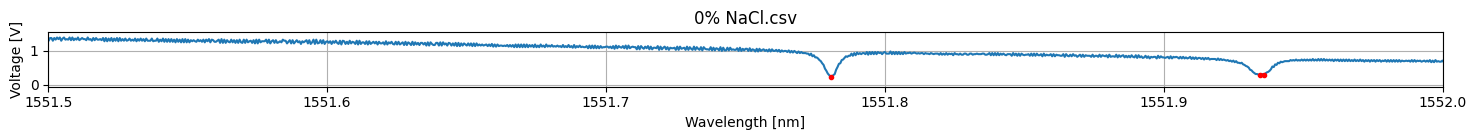

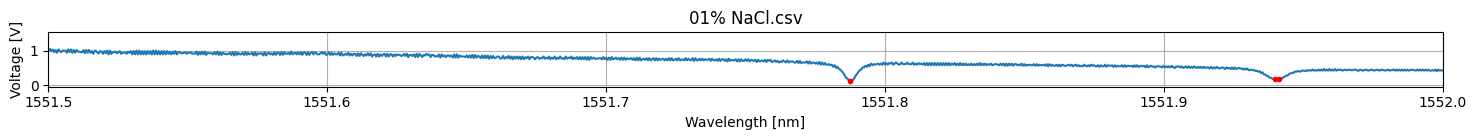

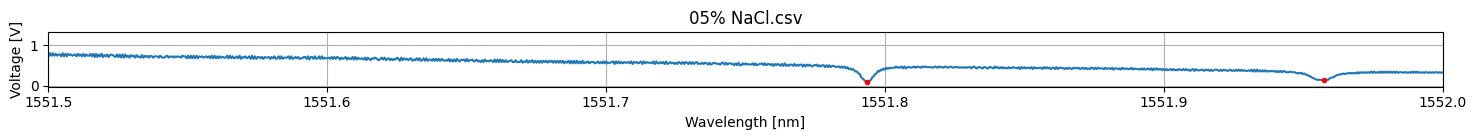

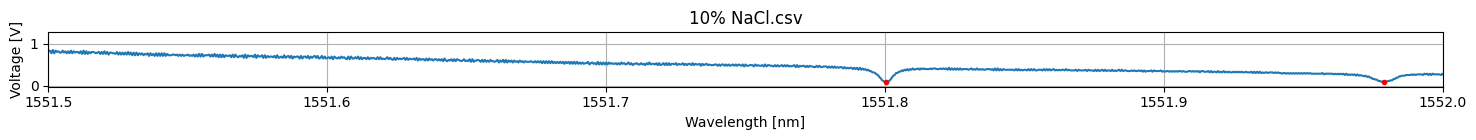

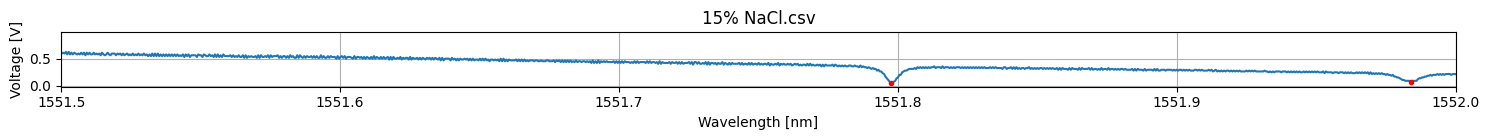


 # # # # # # # # # # # 



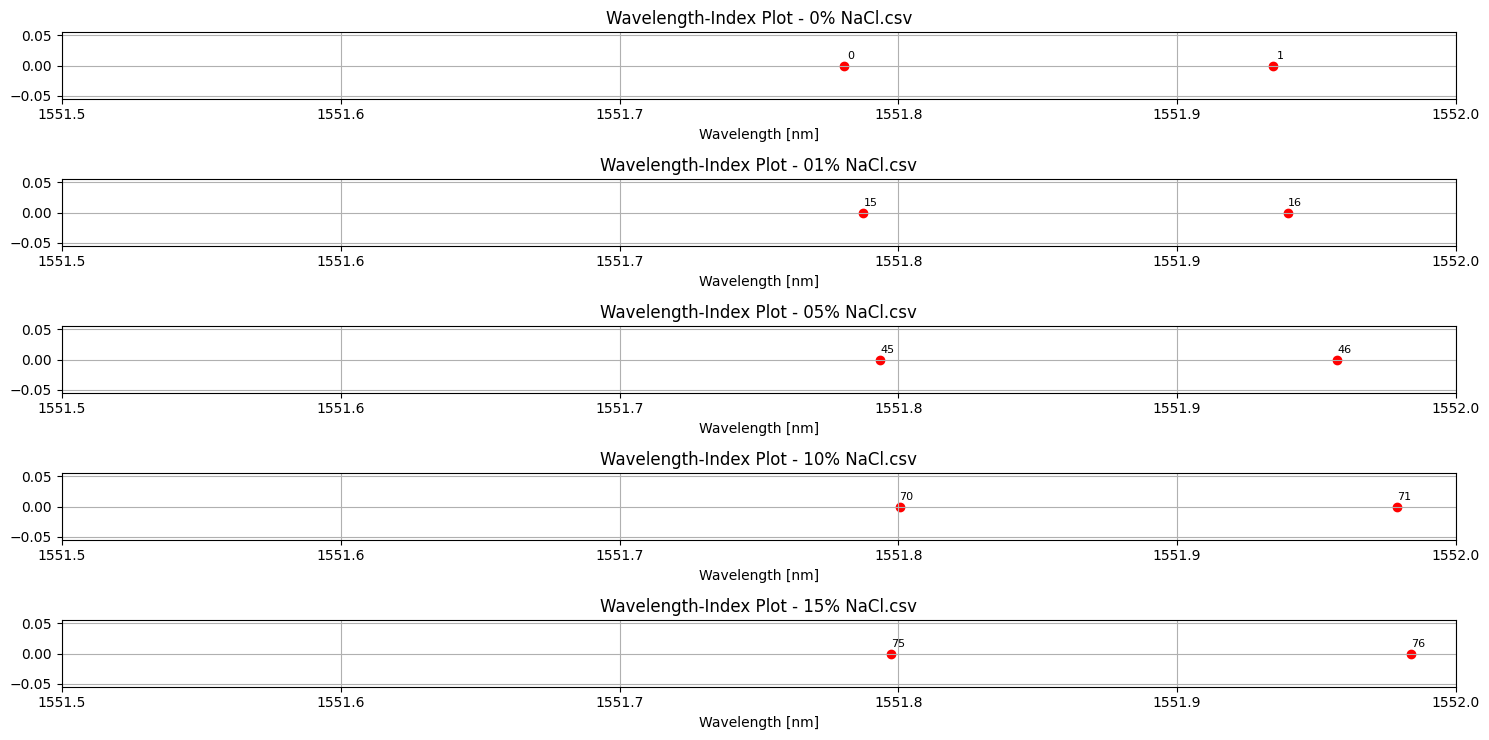

In [35]:
xlim_start = 1551.5                                                               # xlim values are cruical for visualization of resonance peaks. Start and end values can be changed to focus on desired peaks between specific wavelengths.
xlim_end = 1552
prominence = 0.14                                                                 # Prominence is crucial to detect the peaks. As it decreases, smaller peaks can be detected.
peak_max = 1.2                                                                    # Peaks having higher amplitutes than peak_max will not be saved for further progress.
size_figure = 1.5                                                                 # Plot size in X-axis can be adjusted to observe the resonance peaks

filtered_data, data_peak = plot_peaks(data_dict, xlim_start, xlim_end, prominence, peak_max, size_figure)

# Plots will demonstrate peaks and their indexes. After deciding which peak is going to be analyzed in terms of wavelength shift, their index numbers should be provided in the next function as inputs.
# In the example, NaCl experiment data is provided. Peak with index 0 is selected as reference peak, and peaks with indexes 15, 45, 70, and 75 are selected to observe the shift after parameters are altered.
# Difference between reference index in reference condition and other indexes selected from altered conditions are calculated here.

In [5]:
# Function will ask inputs, which are indexes that are selected.
# First input is reference index, in the example, it is index 0.
# Next inputs are 15, 45, 70, and 75.
# After there is no index to be inputed, code has to be terminated by writing "terminate"
# As an output, it'll provide wavelength shifts for each index relative to reference index.

reference_data, differences, selected_indexes, selected_wavenumbers = get_wavenumber_differences(filtered_data)

Enter the index of the reference point or 'terminate' to stop: 0
Reference wavenumber value for index 0 in 0% NaCl.csv : 1551.7805121797192

Please enter the index for corresponding wavenumbers.
Enter an index to retrieve the corresponding wavenumber or 'terminate' to stop: 15
Wavenumber value for index 15 in 01% NaCl.csv : 1551.7875078074503
Enter an index to retrieve the corresponding wavenumber or 'terminate' to stop: 45
Wavenumber value for index 45 in 05% NaCl.csv : 1551.7935040597913
Enter an index to retrieve the corresponding wavenumber or 'terminate' to stop: 70
Wavenumber value for index 70 in 10% NaCl.csv : 1551.8004996875225
Enter an index to retrieve the corresponding wavenumber or 'terminate' to stop: 75
Wavenumber value for index 75 in 15% NaCl.csv : 1551.797501561352
Enter an index to retrieve the corresponding wavenumber or 'terminate' to stop: terminate

Differences from the reference wavenumber:
Difference for index 0 in 0% NaCl.csv: 0.0
Difference for index 15 in 01

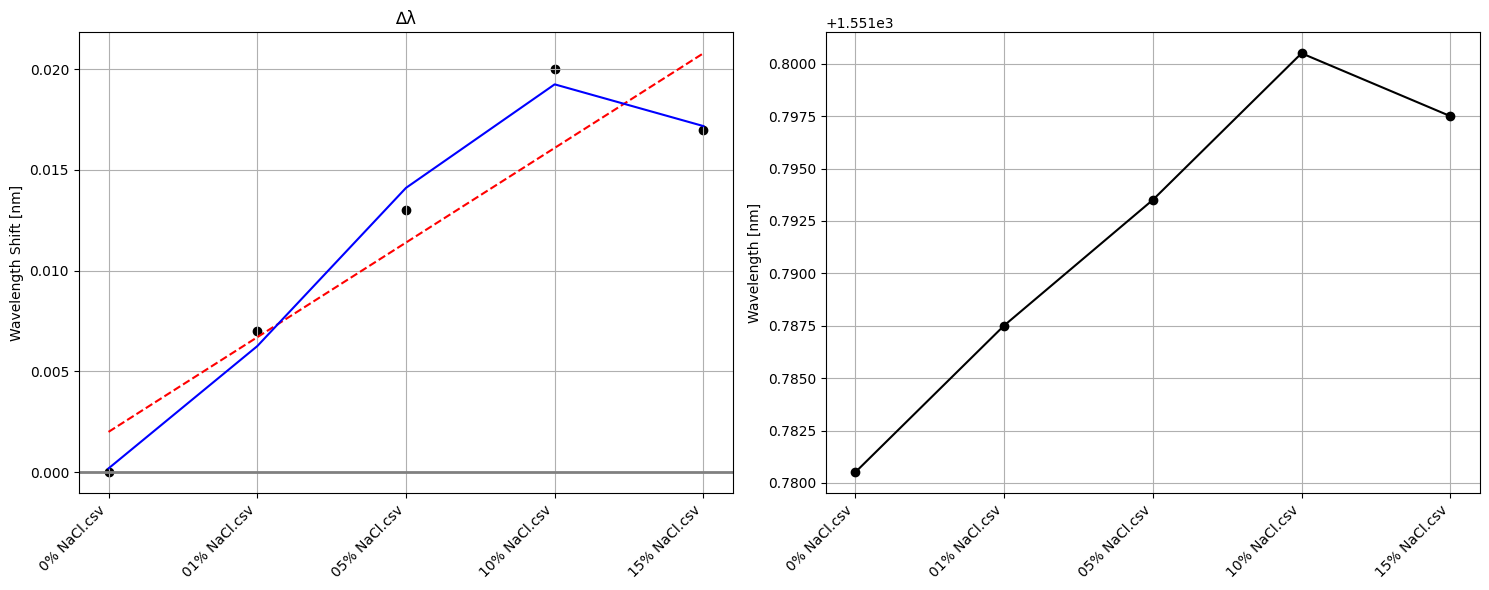

In [6]:
# In this function, wavelength shift and wavelength information for each index are demonstrated. Dashed red-line is linear regression line, and blue curve is polynomial curve with polynomial degree of 3.

plot_wavelength_shift(differences, selected_indexes, filtered_data)

Selected indexes are [0, 15, 45, 70, 75] 

Are there any missing indexes to add (Y/N)? N
Do you want to find the next indexes automatically (A) or manually (M)? A
Wavelength for index 0 in 0% NaCl.csv: 1551.7805121797192
Wavelength for the next index 1 in 0% NaCl.csv: 1551.9344159898046
Difference between consecutive wavelength: 0.15390381008546683

Wavelength for index 15 in 01% NaCl.csv: 1551.7875078074503
Wavelength for the next index 16 in 01% NaCl.csv: 1551.9399125544505
Difference between consecutive wavelength: 0.15240474700021878

Wavelength for index 45 in 05% NaCl.csv: 1551.7935040597913
Wavelength for the next index 46 in 05% NaCl.csv: 1551.9574016237784
Difference between consecutive wavelength: 0.16389756398712052

Wavelength for index 70 in 10% NaCl.csv: 1551.8004996875225
Wavelength for the next index 71 in 10% NaCl.csv: 1551.978888194667
Difference between consecutive wavelength: 0.17838850714451837

Wavelength for index 75 in 15% NaCl.csv: 1551.797501561352
Wavelength 

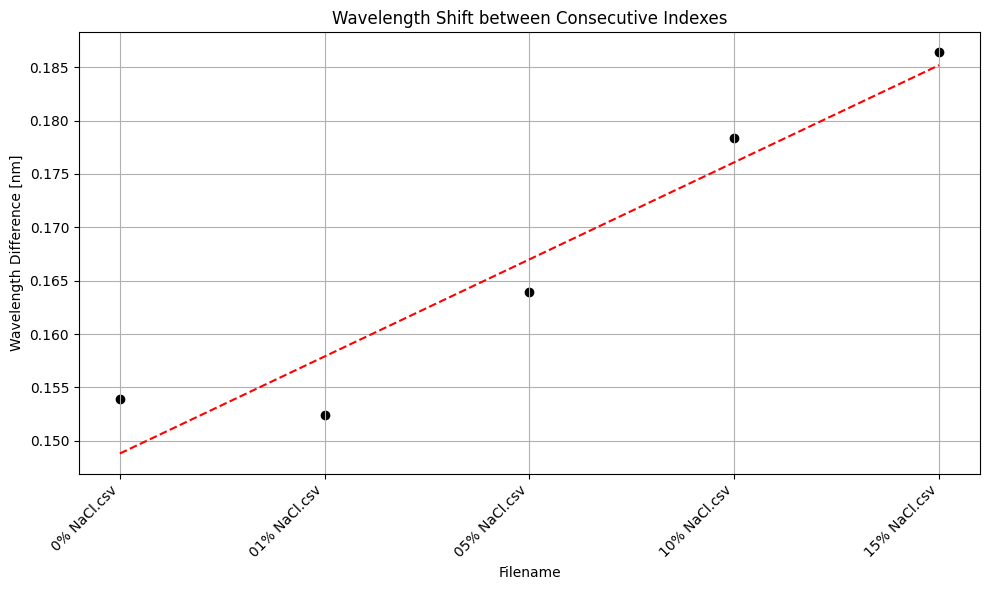

In [7]:
# Alternative function for wavelength shift calculation by checking differences of two consequative indexes for each condition.
# Wavelength of two consequative indexes are substracted, then the substraction value is observed while conditions are altered.
# Problem of wavelength fluctiations can be eliminated with this method. However, resonance peaks may not be suitable all the time.
# Code shows the selected indexes at first. If there is any missing index, please provide it/them. Afterwards, code can further run either automatically or manually.
# In automatic selection, it finds the consequative index itself; however, complex resonance peaks distribution may disturb this method. If so, please use the manual method.
# Identify the most possible consequative index, either moving forward or backward, and provide it to the function.
show_wavenumbers(filtered_data, selected_indexes)